In [0]:
# cost of misclassification is high 
# p of pair of questions , setting thresold
# no strict latency concerns
# interpretability is partially important 

# **Type of machine learning problem--- binary classification**

# **Performance metrics--- logloss**

# **Exploratory Data Analysis**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls 
import os
import gc

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/quora_data'

train.csv


In [5]:
df = pd.read_csv('/content/drive/My Drive/quora_data/train.csv')
print("Number of data points ",df.shape[0])

Number of data points  404290


In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


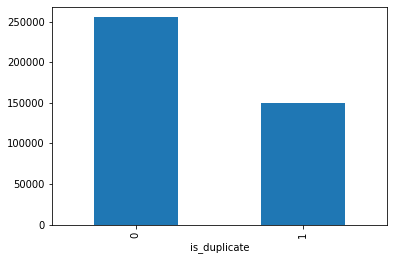

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [10]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


**Number of unique questions**

In [11]:
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))

qs_morethan_onetime = np.sum(qids.value_counts()>1)

print('no of unique questions that appear more than 1:{}({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('max no of times a single question is repeated:{}\n'.format(max(qids.value_counts())))
q_vals = qids.value_counts()
q_vals= q_vals.values

no of unique questions that appear more than 1:111780(20.77953945937505%)

max no of times a single question is repeated:157



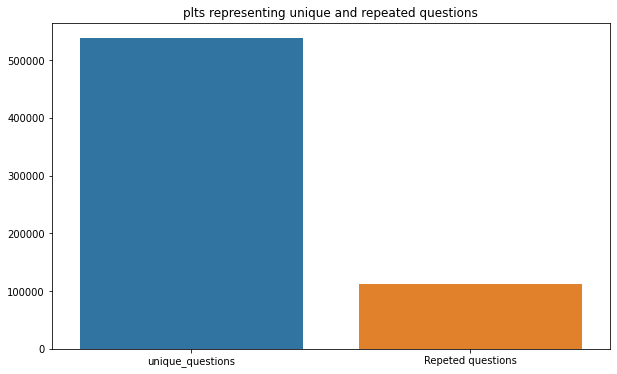

In [12]:
x=["unique_questions","Repeted questions"]
y=[unique_qs, qs_morethan_onetime]

plt.figure(figsize=(10,6))
plt.title("plts representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

**Checking duplicates**

In [13]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('no of duplicate questions',(pair_duplicates).shape[0]-df.shape[0])

no of duplicate questions 0


**No of occurance of each question**

Maximum number of times a single question is repeated: 157



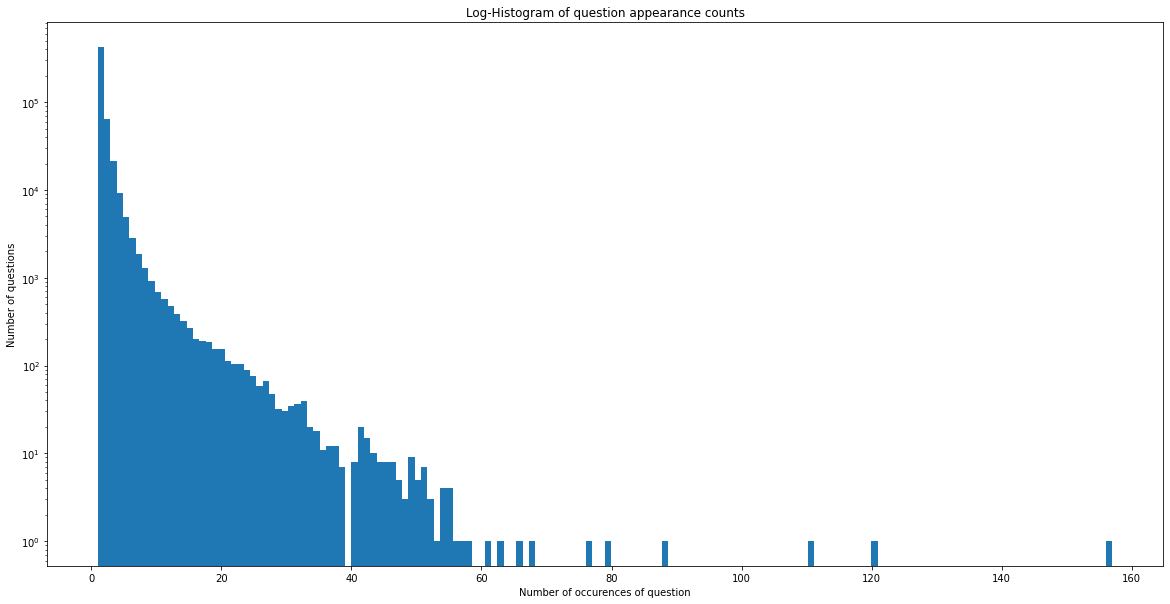

In [14]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

**checking null values**

In [15]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


In [16]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**Basic feature extraction(before cleaning )**

let us construct a few features like:


*   freq_qid1
*   freq_qid2
*   q1len
*   q2len
*   q1_n_words
*   q2_n_words
*   word_Common
*   word_Total
*   word_share
*   freq_qid1+freq_qid2
*   freq_qid1-freq_qid2

In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
  df = pd.read.csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
  df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
  df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
  df[]